# Forecasting - Time Series

Dataset ini berisi informasi seberapa populer kata kunci " Pulau Pari" di google trends selama periode tertentu

> Tujuan utama dari proyek ini adalah memprediksi popularitas wisata pulau pari di 1 tahun kedepan berdasarkan data historis.



In [1]:
# Load Library

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Decomposition of time-series graph
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Data Loading

In [2]:
# Load CSV
df = pd.read_csv('multiTimeline.csv', skiprows=2)
df.head(10)

,Week,Pulau Pari: (Indonesia)
0,2022-03-27,16
1,2022-04-03,13
2,2022-04-10,18
3,2022-04-17,29
4,2022-04-24,35
5,2022-05-01,95
6,2022-05-08,62
7,2022-05-15,47
8,2022-05-22,35
9,2022-05-29,32


In [3]:
df.tail()

,Week,Pulau Pari: (Indonesia)
121,2024-07-21,43
122,2024-07-28,34
123,2024-08-04,32
124,2024-08-11,36
125,2024-08-18,29


## Check Data Info

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Week                     126 non-null    object
 1   Pulau Pari: (Indonesia)  126 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


- dataset terdiri dari 126 entries dan 2 kolom
- column `Week` masih berbentuk object, sehingga harus diubah ke datetime

In [5]:
df.columns

Index(['Week', 'Pulau Pari: (Indonesia)'], dtype='object')

## Change Name and Data Type Columns 

In [6]:
# Mengubah nama Kolom
df.columns = ['Week','Pulau_Pari']
# Mengubah tipe data kolom Week
df['Week'] = pd.to_datetime(df['Week'])

## Check Missing Values

In [7]:
df.isnull().sum()

Week          0
Pulau_Pari    0
dtype: int64

Tidak ada kolom yang missing values

## Check Duplicated Data

In [8]:
df.duplicated().sum()

0

# Exploratory Data Analysis (EDA)

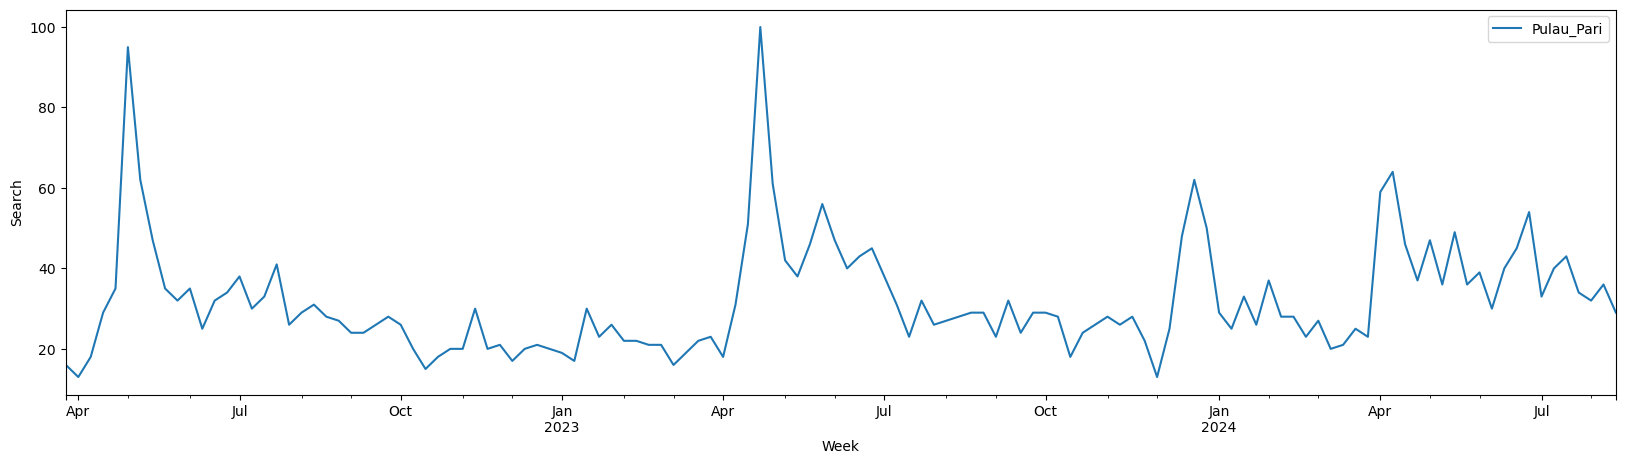

In [46]:
# plotting dataset
df['Pulau_Pari'] = df['Pulau_Pari'].astype(int)
df.plot(figsize=(20,5))
plt.xlabel('Week')
plt.ylabel('Search')
plt.show()

Data menunjukkan pola berulang di tiap tahunnya seperti di bulan April 2022 dan di bulan April 2023 selalu mengalami peningkatan signifikan.

## Time series decomposition

In [10]:
# Hitung selisih waktu antar baris
time_diffs = df.index.to_series().diff().dropna()

# Lihat beberapa selisih waktu
print(time_diffs.head(10))

Week
2022-04-03   7 days
2022-04-10   7 days
2022-04-17   7 days
2022-04-24   7 days
2022-05-01   7 days
2022-05-08   7 days
2022-05-15   7 days
2022-05-22   7 days
2022-05-29   7 days
2022-06-05   7 days
Name: Week, dtype: timedelta64[ns]


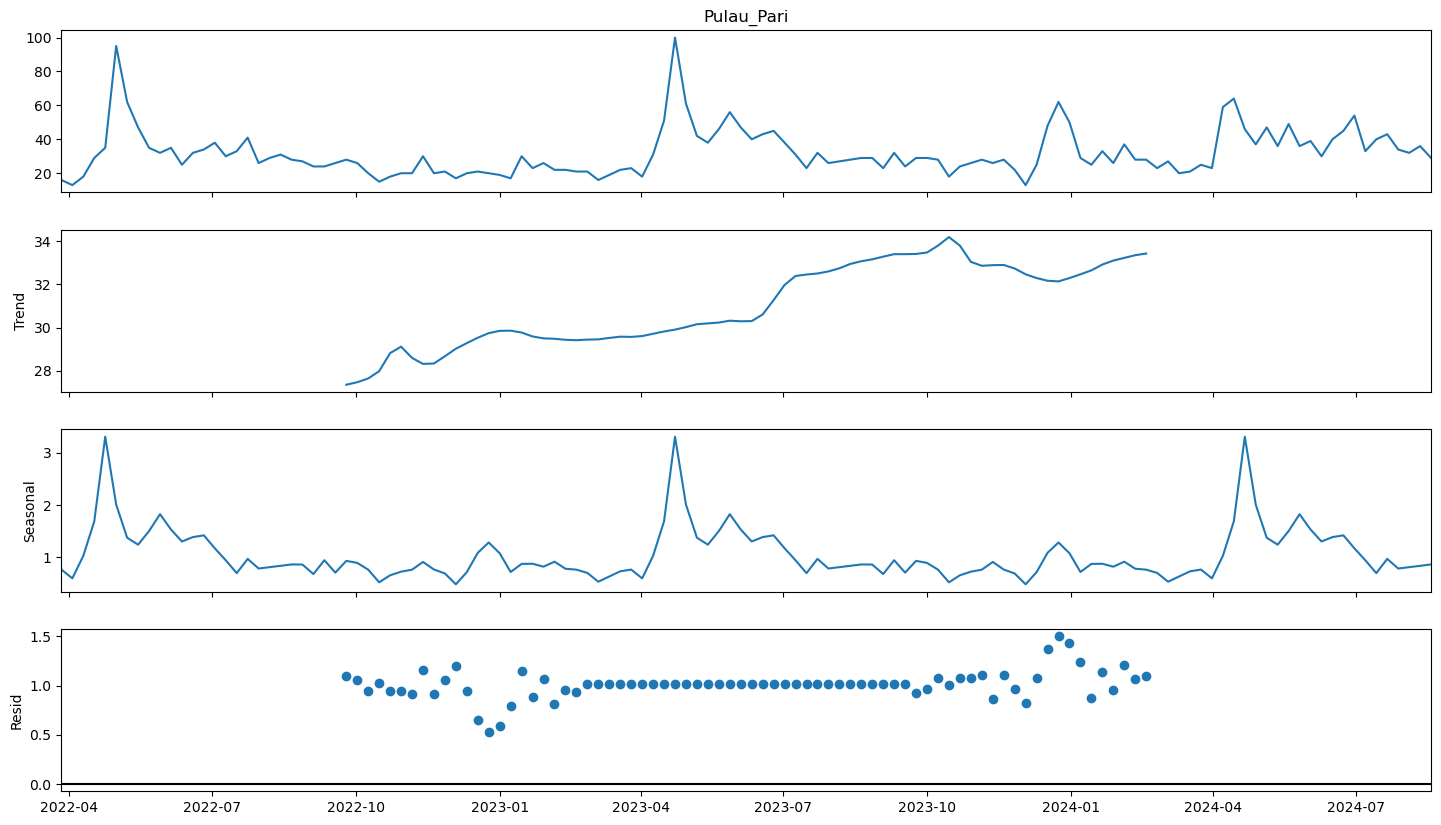

In [47]:
result = seasonal_decompose(df['Pulau_Pari'], model='multiplicative')
fig = result.plot()
fig.set_size_inches(16, 9)
plt.show()

- Secara Tren: Tren menunjukkan adanya peningkatan bertahap dari waktu ke waktu
- Secara Seasonality: Menunjukkan fluaktuasi yang cukup signifikan setiap tahun, ini menunjukkan ada pola musiman.

## Stationarity

In [50]:
# Create function to check stationarity
def check_stationarity(series):

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [12]:
df.shape

(126, 1)

In [51]:
# Splitting dataset into train and test set

train = df[:101]
test = df[101:]

print('Train size : ', train.shape)
print('Test size : ', test.shape)

Train size :  (101, 1)
Test size :  (25, 1)


In [52]:
# Check stationarity of the dataset

check_stationarity(train)

ADF Statistic: -3.477037
p-value: 0.008597
Critical Values:
	1%: -3.500
	5%: -2.892
	10%: -2.583
Stationary


karena p value < 0.05 , maka dapat disimpulkan bahwa data stasioner, artinya nilai d pada model (p, d ,q) ARIMA akan bernilai 0

## ACF & PACF

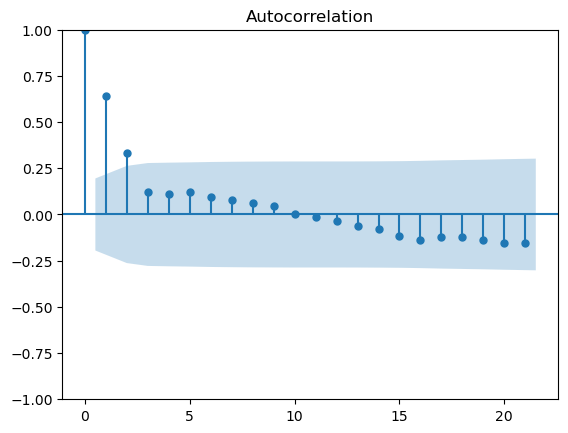

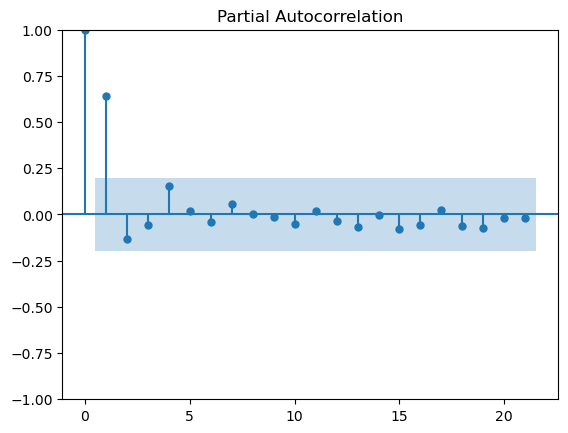

In [16]:
plot_acf(train)
plot_pacf(train)
plt.show()

Lags occur at:

ACF (q) = 1,2

PACF (p) = 1

# Model Definition and Training

## ARIMA

In [55]:
# Create a function to find best model

def find_best_arima_params(data, num_p, num_d, num_q):
  df1 = pd.DataFrame() #We make a pandas dataframe to ease our work, you can use any way that makes you comfortable and work easly
  pdq = [[],[],[]] #This list for storing the combinations of p and q
  aic = [] # This list for storing aic value
  for p in range(num_p + 1): #plus one is to make the range up to num_p since python range only ranging from 0 to N-1
    for d in range(num_d + 1):
      for q in range(num_q + 1):
        # #if p!=0 and q!=0: #this logic will avoid (0,0) value which is not correct
        try: #Using exception to avoid the error while training the model with certain p and q value
          model = ARIMA(data, order=(p, d, q))
          result = model.fit()
          pdq[0].append(p)
          pdq[1].append(d)
          pdq[2].append(q)
          aic.append(result.aic)
        except:
          pass #If there is an error caused by the calculation, it will be skipped to the next iteration

  df1['p'] = pdq[0]
  df1['d'] = pdq[1]
  df1['q'] = pdq[2]
  df1['AIC'] = aic

  df1.sort_values('AIC', inplace=True)

  return df1.p.iloc[0], df1.d.iloc[0], df1.q.iloc[0], df1.AIC.iloc[0], df1

In [56]:
# Find the best parameters for ARIMA with max p=2, d=2, q=2
find_best_arima_params(train['Pulau_Pari'], 2, 2, 2)

c:\Users\Khalil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\Khalil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\Khalil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\Khalil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\Khalil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-

(1,
 1,
 1,
 769.5455845783899,
     p  d  q         AIC
 13  1  1  1  769.545585
 22  2  1  1  770.148178
 14  1  1  2  770.415509
 23  2  1  2  772.086397
 2   0  0  2  772.200813
 11  1  0  2  773.402654
 9   1  0  0  773.594292
 18  2  0  0  773.950327
 10  1  0  1  774.302923
 20  2  0  2  775.377693
 19  2  0  1  775.849644
 5   0  1  2  777.879916
 7   0  2  1  781.208472
 3   0  1  0  781.405618
 4   0  1  1  782.586613
 8   0  2  2  782.617907
 16  1  2  1  782.800028
 12  1  1  0  782.860823
 21  2  1  0  782.902364
 25  2  2  1  783.107832
 17  1  2  2  784.481351
 26  2  2  2  785.890602
 1   0  0  1  786.478944
 24  2  2  0  823.417497
 0   0  0  0  825.178148
 15  1  2  0  827.531604
 6   0  2  0  850.184243)

Best ARIMA order: (1, 1, 1)

In [58]:
# Train ARIMA with best combinations
arima = ARIMA(train, order=(1, 1, 1)).fit()
print('The AIC is', arima.aic)

The AIC is 769.5455845783899


c:\Users\Khalil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\Khalil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\Khalil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\Khalil\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Khalil\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible sta

Dari hasil di atas, didapatkan informasi bahwa nilai p,d,q dengan kombinasi yang terbaik adalah (1, 1, 1) denga nilai AIC 769.5. Selanjutnya, akan dilakukan prediksi menggunakan data test dengan nilai p,d,q yang sudah ditentukan, yaitu (1, 1, 1).

In [59]:
# Predict test-set
arima_pred_test = arima.predict(start='2024-03-03', end='2024-08-18')
arima_pred_test = pd.DataFrame(arima_pred_test)
arima_pred_test.columns=['Popularity_predict']

# Combine the actual test data and the predictions
act_vs_pred_arima = pd.concat([test, arima_pred_test], axis=1)

# Ensure the index is in datetime format
act_vs_pred_arima.index = pd.to_datetime(act_vs_pred_arima.index)

# Filter data for the date range
start_date = '2024-03-03'
end_date = '2024-08-18'
filtered_data1 = act_vs_pred_arima.loc[start_date:end_date]
filtered_data1

,Pulau_Pari,Popularity_predict
2024-03-03,27,25.444151
2024-03-10,20,27.053660
2024-03-17,21,28.113544
2024-03-24,25,28.811494
2024-03-31,23,29.271104
2024-04-07,59,29.573763
2024-04-14,64,29.773069
2024-04-21,46,29.904315
2024-04-28,37,29.990742
2024-05-05,47,30.047656


## SARIMA

In [60]:
def find_best_sarimax_params(data, num_p, num_d, num_q, num_s):
    """
    Function to find the best parameters for SARIMAX model.

    Parameters:
    data (pd.Series): The time series data.
    num_p (int): Maximum value of p (autoregressive).
    num_d (int): Maximum value of d (differencing).
    num_q (int): Maximum value of q (moving average).
    num_s (int): The seasonal period.

    Returns:
    tuple: Best parameters (p, d, q, s) and corresponding AIC value.
    """
    df1 = pd.DataFrame()  # Create a DataFrame to store the results
    pdqs = []  # List for storing combinations of p, d, q
    aic = []   # List for storing AIC values

    for p in range(num_p + 1):  # Loop through p values
        for d in range(num_d + 1):  # Loop through d values
            for q in range(num_q + 1):  # Loop through q values
                try:
                    # Fit the SARIMAX model with seasonal order
                    model = SARIMAX(data, order=(p, d, q), seasonal_order=(0, 0, 0, num_s))
                    result = model.fit(disp=False)  # Fit the model and suppress output
                    pdqs.append((p, d, q))  # Store the parameters
                    aic.append(result.aic)  # Store the AIC value
                except:
                    continue  # Skip any errors during fitting

    # Create a DataFrame from the results
    df1['p'] = [params[0] for params in pdqs]
    df1['d'] = [params[1] for params in pdqs]
    df1['q'] = [params[2] for params in pdqs]
    df1['AIC'] = aic

    df1.sort_values('AIC', inplace=True)  # Sort by AIC values

    # Return the best parameters and AIC value
    best_params = df1.iloc[0]
    return best_params['p'], best_params['d'], best_params['q'], best_params['AIC'], df1

In [61]:
# Example usage: Find the best parameters for SARIMAX with max p=2, d=2, q=2 and seasonal period s=52
best_sarimax_params = find_best_sarimax_params(train['Pulau_Pari'], 2, 2, 2, 52)
print(f'Best SARIMAX parameters: p={best_sarimax_params[0]}, d={best_sarimax_params[1]}, q={best_sarimax_params[2]}, AIC={best_sarimax_params[3]}')

c:\Users\Khalil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\Khalil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\Khalil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\Khalil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\Khalil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-

Best SARIMAX parameters: p=1.0, d=1.0, q=1.0, AIC=769.5455845783899


c:\Users\Khalil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\Khalil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


Best SARIMAX order: (1, 1, 1)

In [62]:
# Train SARIMAX with best combinations
sarimax = SARIMAX(train, order=(1, 1, 1),seasonal_order=(1, 1, 1, 52)).fit()
sarimax.summary()

c:\Users\Khalil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\Khalil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\Khalil\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Khalil\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Pulau_Pari   No. Observations:                  101
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -197.925
Date:                            Wed, 30 Oct 2024   AIC                            405.849
Time:                                    21:10:06   BIC                            415.205
Sample:                                03-27-2022   HQIC                           409.385
                                     - 02-25-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2649      0.105      2.530      0.011       0.060       0.470
ma.L1         -0.9995     16.424     -0.061      0.951     -33.190      31.191
ar.S.L52      -0.7154   2154.740     -0.000      1.000   -4223.929    4222.498
ma.S.L52      -0.6465   6452.946     -0.000      1.000   -1.26e+04    1.26e+04
sigma2        43.4154    179.345      0.242      0.809    -308.094     394.925
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               120.95
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                            -0.82
Prob(H) (two-sided):                  0.02   Kurtosis:                        10.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.65e+18. Standard errors may be unstable.
"""

In [63]:
# Predict test-set 
sar_pred_test = sarimax.predict(start='2024-03-03', end='2024-08-18')
sar_pred_test = pd.DataFrame(sar_pred_test)
sar_pred_test.columns=['Popularity_predict']

# Combine the actual test data and the predictions
act_vs_pred_sar = pd.concat([test, sar_pred_test], axis=1)

# Ensure the index is in datetime format
act_vs_pred_sar.index = pd.to_datetime(act_vs_pred_sar.index)

# Filter data for the date range '2024-03-03', end='2024-08-18'
start_date = '2024-03-03'
end_date = '2024-08-18'
filtered_data2 = act_vs_pred_sar.loc[start_date:end_date]
filtered_data2

,Pulau_Pari,Popularity_predict
2024-03-03,27,21.091028
2024-03-10,20,24.877114
2024-03-17,21,27.965797
2024-03-24,25,28.549731
2024-03-31,23,25.254682
2024-04-07,59,31.454638
2024-04-14,64,43.803683
2024-04-21,46,56.246421
2024-04-28,37,101.410648
2024-05-05,47,70.509408


# Model Evaluation

## ARIMA

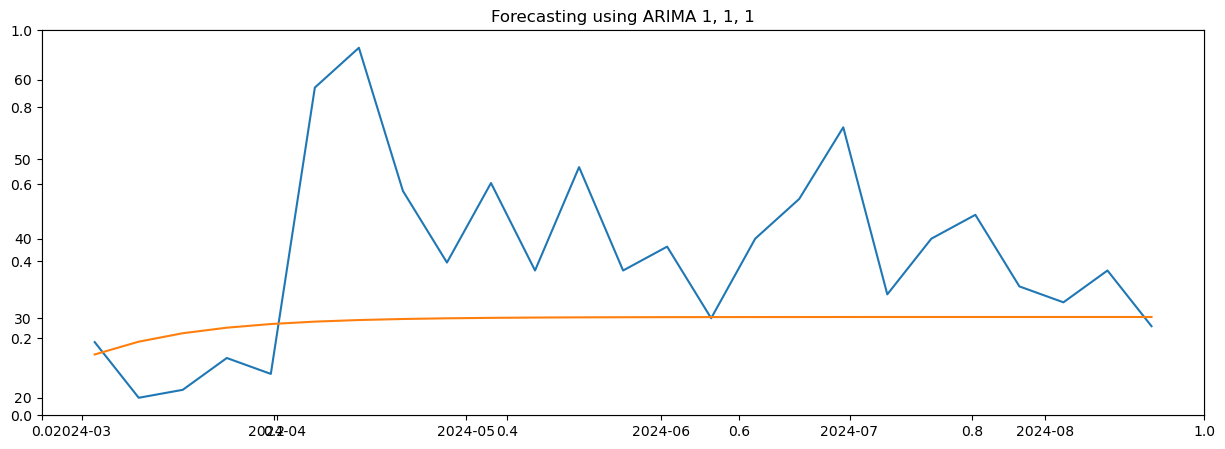

In [64]:
# Plot all dataset including prediction

fig, ax = plt.subplots(figsize=(15,5))
ax1 = fig.add_subplot(111)
ax1.set_title('Forecasting using ARIMA 1, 1, 1')
ax1.plot(filtered_data1)

In [65]:
# check the MAE
print('MAE test  : ', mean_absolute_error(test, arima_pred_test))
# check the MAE
print('MAE Percentage test  : ', mean_absolute_percentage_error(test, arima_pred_test)*100,"%")

MAE test  :  10.238731004907523
MAE Percentage test  :  24.297967610975245 %


dengan MAE sekitar 10, Artinya prediksi model secara rata-rata meleset dikisaran +- 10 poin dari nilai sebenarnya

## SARIMA

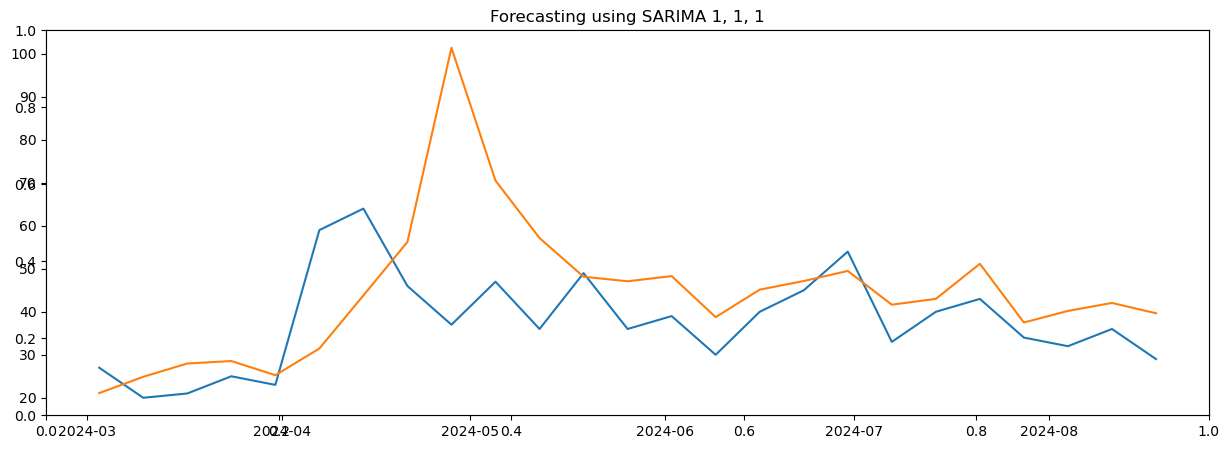

In [66]:
# Plot all dataset including prediction

fig, ax = plt.subplots(figsize=(15,5))
ax1 = fig.add_subplot(111)
ax1.set_title('Forecasting using SARIMA 1, 1, 1')
ax1.plot(filtered_data2)

In [67]:
# check the MAE
print('MAE test  : ', mean_absolute_error(test, sar_pred_test))
# check the MAE
print('MAE Percentage test  : ', mean_absolute_percentage_error(test, sar_pred_test)*100,"%")

MAE test  :  11.227248504556268
MAE Percentage test  :  29.627683810782113 %


Jika menggunakan SARIMA, score MAE lebih tinggi daripada ARIMA dengan angka kurang lebih 11 atau 29.6%

# Model Inference

In [70]:
# forecasting 1 tahun ke depan
forecast = sarimax.forecast(steps=52) #forecast periods
# get confidence intervals
forecast_results = sarimax.get_forecast(steps=52)
conf_int = forecast_results.conf_int(alpha=0.05)

# make as pandas series
forecast_series = pd.Series(forecast, index=test.index)
lower_series = pd.Series(conf_int.iloc[:, 0], index=test.index)
upper_series = pd.Series(conf_int.iloc[:, 1], index=test.index)

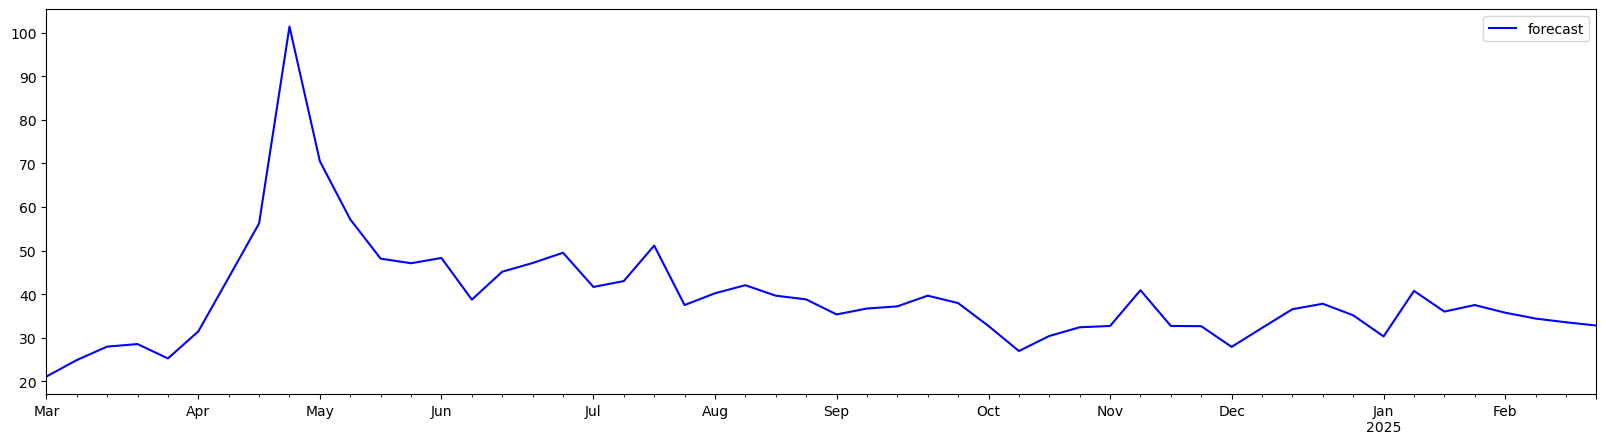

In [71]:
# make a forecast
forecast.plot(color='blue', label = 'forecast',figsize=(20,5))
plt.legend()